In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import os


## Gradient Boosting on PCA Results

In [12]:
# Directory where PCA results are saved
pca_dir = "../../data/pca_data/byBasin_pca"
result_dir = "../../data/performance_comparison"

# Output directories for plots and predictions
plot_dir = "../../images/gradient_boosting_plots/gradient_boosting_withPCA"
predicted_data_dir = "../../data/predicted_data/gradient_boosting_withPCA"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(predicted_data_dir, exist_ok=True)

# Get a list of all PCA result files
pca_files = [f for f in os.listdir(pca_dir) if f.endswith('_pca_with_target.csv')]

# Dictionary to store results for each basin
results = {}

# Process each PCA result file
for file in pca_files:
    basin_name = file.replace('_pca_with_target.csv', '').replace(' ', '_')  # Replace spaces with underscores
    sanitized_basin_name = basin_name.replace(' ', '_')  # Sanitize basin name for file paths
    pca_df = pd.read_csv(f"{pca_dir}/{file}")

    # Separate data with known and unknown 'Li' values
    known_data = pca_df.dropna(subset=['Li'])
    unknown_data = pca_df[pca_df['Li'].isnull()]

    # Prepare training and testing data from known data
    principal_components = [f'PC{i+1}' for i in range(10)]  # Use the first 10 principal components
    X_known = known_data[principal_components]
    y_known = known_data['Li']
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

    # Initialize and train Gradient Boosting Regressor
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbr.fit(X_train, y_train)

    # Predict and evaluate on known test data
    y_pred = gbr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    explained_variance = explained_variance_score(y_test, y_pred)

    # Store results for known data evaluation
    results[basin_name] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Explained Variance': explained_variance
    }
    print(f"Basin: {sanitized_basin_name} - MSE: {mse}, R2: {r2}, MAE: {mae}, RMSE: {rmse}, Explained Variance: {explained_variance}")


    
    # Plot actual vs predicted and save the plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    colors = ['lightblue', 'lightgreen', 'palegoldenrod', 'lightsalmon']
    percentage_ranges = [5, 15, 25, 50]
    for i, percentage in enumerate(percentage_ranges):
        threshold = (percentage / 100) * np.mean(y_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min() + threshold, y_test.max() + threshold],
                 linestyle='--', color=colors[i], label=f'Within {percentage}%')
        plt.plot([y_test.min(), y_test.max()], [y_test.min() - threshold, y_test.max() - threshold],
                 linestyle='--', color=colors[i])
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.xlabel('Actual Li Concentrations')
    plt.ylabel('Predicted Li Concentrations')
    plt.title(f'Actual vs. Predicted for {sanitized_basin_name}')
    plt.legend()
    plot_path = os.path.join(plot_dir, f"{sanitized_basin_name}_actual_predicted_gradient_boosting_pca.png")
    plt.savefig(plot_path)
    plt.close()

    # Predict unknown 'Li' values if there are any
    if not unknown_data.empty:
        X_unknown = unknown_data[principal_components]
        y_unknown_pred = gbr.predict(X_unknown)
        unknown_data['Predicted_Li'] = y_unknown_pred

        pca_df.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred

        # Save predicted data for unknown values
        predicted_data_path = os.path.join(predicted_data_dir, f"{sanitized_basin_name}_predicted_Li_gradient_boosting_pca.csv")
        pca_df.to_csv(predicted_data_path, index=False)

        # Plot predictions for unknown data and save the plot
        plt.figure(figsize=(6, 6))
        plt.hist(y_unknown_pred, bins=30, alpha=0.75)
        plt.xlabel('Predicted Lithium Concentration')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Predicted Lithium Concentrations for New Samples in {sanitized_basin_name}')
        plot_hist_path = os.path.join(plot_dir, f"{sanitized_basin_name}_predicted_distribution_gradient_boosting_pca.png")
        plt.savefig(plot_hist_path)
        plt.close()

# Convert results to a DataFrame for better visualization or further analysis
results_df_with_pca = pd.DataFrame(results).T
results_df_with_pca.to_csv(os.path.join(result_dir, "gradient_boosting_performance_pca.csv"), index_label='Basin')

print("Saved performance metrics with PCA to CSV.")

c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\1863191770.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred


Basin: Anadarko - MSE: 3515.827647608427, R2: 0.6468311109784811, MAE: 17.580954595547304, RMSE: 59.29441497821213, Explained Variance: 0.6545109829949916


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\1863191770.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred


Basin: Appalachian - MSE: 1237.3783540659697, R2: 0.661328782291387, MAE: 25.198242805399584, RMSE: 35.1763891561651, Explained Variance: 0.6792417279877886


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Fort_Worth - MSE: 581.3218291931303, R2: 0.5256587389714706, MAE: 14.663941713305082, RMSE: 24.110616524533963, Explained Variance: 0.5946441048967377


C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\1863191770.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Great_Plains - MSE: 39871.24413010937, R2: -0.06872715116172268, MAE: 57.180655553121014, RMSE: 199.67785087512678, Explained Variance: 0.014617969312910817


C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\1863191770.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\1863191770.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Basin: Gulf_Coast - MSE: 6096.519163048429, R2: -0.07782286025085328, MAE: 22.05953774516324, RMSE: 78.08020980407538, Explained Variance: -0.05132080453197152


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Illinois - MSE: 196.2417937045676, R2: -0.026369299824667403, MAE: 10.138688623205088, RMSE: 14.008632827816125, Explained Variance: 0.25962332538607336


C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\1863191770.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\1863191770.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Basin: Michigan - MSE: 132.0456409211949, R2: 0.6696591389751777, MAE: 7.198711682194668, RMSE: 11.491111387554943, Explained Variance: 0.6758946025820012


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Oklahoma_Platform - MSE: 175.85685123579648, R2: 0.44017357019921266, MAE: 9.407608952712124, RMSE: 13.261102941904813, Explained Variance: 0.47743177678739757


C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\1863191770.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\1863191770.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Basin: Pacific - MSE: 13.923804265697141, R2: -0.34461097139272723, MAE: 1.873948131417637, RMSE: 3.7314614115245974, Explained Variance: -0.33427104757632486


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Permian - MSE: 5480.308899969941, R2: -0.07770371434607704, MAE: 17.884389260086653, RMSE: 74.02910846396802, Explained Variance: -0.06924905031399597


C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\1863191770.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\1863191770.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Basin: Rocky_Mountain - MSE: 83.56444769518521, R2: 0.6104523764449548, MAE: 3.999971574261971, RMSE: 9.141359182046465, Explained Variance: 0.6105407594054189


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Williston - MSE: 682.7841659486542, R2: 0.7037666375952439, MAE: 11.99428319465179, RMSE: 26.130139034238876, Explained Variance: 0.7051075243448985


C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\1863191770.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred


Saved performance metrics with PCA to CSV.


## Gradient Boosting on Imputed Data without PCA

In [3]:
# Load the dataset with all basins
df = pd.read_csv("../../data/df_output/df_cleaned_imputed.csv")

# Output directories for plots and predictions
plot_dir = "../../images/gradient_boosting_plots/gradient_boosting_withoutPCA"
predicted_data_dir = "../../data/predicted_data/gradient_boosting_withoutPCA"
result_dir = "../../data/performance_comparison"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(predicted_data_dir, exist_ok=True)

# Define features to use for predicting 'Li'
predictors = ['B', 'Ba', 'Br', 'HCO3', 'FeTot', 'K', 'Na', 'Cl', 'SO4', 'Mg', 'Ca', 'Sr', 'Zn', 'TDS', 'DEPTHUPPER']

# Dictionary to store results for each basin
results = {}

# Loop through each unique basin category
for basin in df['BASIN_CATEGORY'].unique():
    sanitized_basin = basin.replace(' ', '_')  # Replace spaces with underscores
    print(f"Processing Gradient Boosting for {basin}")
    df_basin = df[df['BASIN_CATEGORY'] == basin]

    # Separate data with known and unknown 'Li' values
    known_data = df_basin.dropna(subset=['Li'])
    unknown_data = df_basin[df_basin['Li'].isnull()]

    # Prepare training and testing data from known data
    X_known = known_data[predictors]
    y_known = known_data['Li']
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

    # Initialize and train Gradient Boosting Regressor
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbr.fit(X_train, y_train)

    # Predict and evaluate on known test data
    y_pred = gbr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    explained_variance = explained_variance_score(y_test, y_pred)

    # Store results for known data evaluation
    results[basin] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Explained Variance': explained_variance
    }
    print(f"Basin: {basin} - MSE: {mse}, R2: {r2}, MAE: {mae}, RMSE: {rmse}, Explained Variance: {explained_variance}")

    # Plot actual vs predicted and save the plot, including percentage lines
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    percentage_ranges = [5, 15, 25, 50]
    colors = ['lightblue', 'lightgreen', 'palegoldenrod', 'lightsalmon']
    for i, percentage in enumerate(percentage_ranges):
        threshold = (percentage / 100) * np.mean(y_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min() + threshold, y_test.max() + threshold],
                 linestyle='--', color=colors[i], label=f'Within {percentage}%')
        plt.plot([y_test.min(), y_test.max()], [y_test.min() - threshold, y_test.max() - threshold],
                 linestyle='--', color=colors[i])

    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.xlabel('Actual Li Concentrations')
    plt.ylabel('Predicted Li Concentrations')
    plt.title(f'Actual vs. Predicted for {basin}')
    plt.legend()
    plot_path = os.path.join(plot_dir, f"{sanitized_basin}_actual_predicted_gradient_boosting_no_pca.png")
    plt.savefig(plot_path)
    plt.close()

    # Predict unknown 'Li' values if there are any
    if not unknown_data.empty:
        X_unknown = unknown_data[predictors]
        y_unknown_pred = gbr.predict(X_unknown)
        unknown_data['Predicted_Li'] = y_unknown_pred

        # Merge the predictions back to the main DataFrame
        df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred

        # Optional: to also show original 'Li' in the same column where available
        df_basin.loc[known_data.index, 'Predicted_Li'] = known_data['Li']

        # Save the full basin DataFrame including both known 'Li' and predicted 'Li' values
        predicted_data_path = os.path.join(predicted_data_dir, f"{sanitized_basin}_predicted_Li_gradient_boosting_no_pca.csv")
        df_basin.to_csv(predicted_data_path, index=False)

        # Plot predictions for unknown data and save the plot
        plt.figure(figsize=(6, 6))
        plt.hist(y_unknown_pred, bins=30, alpha=0.75)
        plt.xlabel('Predicted Lithium Concentration')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Predicted Lithium Concentrations for New Samples in {basin}')
        plot_hist_path = os.path.join(plot_dir, f"{sanitized_basin}_predicted_distribution_gradient_boosting_no_pca.png")
        plt.savefig(plot_hist_path)
        plt.close()

# Convert results to a DataFrame for better visualization or further analysis
results_df_without_pca = pd.DataFrame(results).T
results_df_without_pca.to_csv(os.path.join(result_dir, "gradient_boosting_performance_no_pca.csv"), index_label='Basin')

print("Saved performance metrics without PCA to CSV.")

Processing Gradient Boosting for Appalachian


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Basin: Appalachian - MSE: 1055.653259749568, R2: 0.7110670525448741, MAE: 21.436445040100786, RMSE: 32.49081808372279, Explained Variance: 0.7206781081222746
Processing Gradient Boosting for Permian


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Basin: Permian - MSE: 4843.173495393815, R2: 0.04758907563823345, MAE: 15.112378626932456, RMSE: 69.59291268077386, Explained Variance: 0.06105579455260646
Processing Gradient Boosting for Oklahoma Platform


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Oklahoma Platform - MSE: 217.83899052556615, R2: 0.30652673762583926, MAE: 10.271268586623961, RMSE: 14.75936958428666, Explained Variance: 0.3446421429373965


C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Gulf Coast


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred


Basin: Gulf Coast - MSE: 1055.7620203411466, R2: 0.8133485009929304, MAE: 13.681516829684803, RMSE: 32.49249175334429, Explained Variance: 0.8210163559399734


C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Williston


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Basin: Williston - MSE: 139.4588885595948, R2: 0.9394942391233694, MAE: 6.815602437787958, RMSE: 11.809271296722537, Explained Variance: 0.9397679308819327


C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Michigan
Basin: Michigan - MSE: 85.15544764152553, R2: 0.7869651455465769, MAE: 6.296938432980078, RMSE: 9.227970938485097, Explained Variance: 0.7885612468496552


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Processing Gradient Boosting for Pacific
Basin: Pacific - MSE: 1.5763555437948142, R2: 0.8477725685771027, MAE: 0.7416603997405675, RMSE: 1.2555299852232977, Explained Variance: 0.8517457443455315


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Processing Gradient Boosting for Illinois
Basin: Illinois - MSE: 78.35288174883135, R2: 0.5902045590713472, MAE: 6.134857289035555, RMSE: 8.85171631655869, Explained Variance: 0.6422502416922062


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Processing Gradient Boosting for Great Plains
Basin: Great Plains - MSE: 40194.40189544055, R2: -0.07738922041622498, MAE: 57.232000710696255, RMSE: 200.4854156676753, Explained Variance: 0.006367902846831197


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Processing Gradient Boosting for Anadarko
Basin: Anadarko - MSE: 4049.6804296461664, R2: 0.593204991375728, MAE: 23.61042807464979, RMSE: 63.63709947543309, Explained Variance: 0.595387466070225


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Processing Gradient Boosting for Rocky Mountain


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Basin: Rocky Mountain - MSE: 63.67401708653836, R2: 0.7031744632748466, MAE: 3.637676693206302, RMSE: 7.979600058056692, Explained Variance: 0.7063200919819765
Processing Gradient Boosting for Fort Worth
Basin: Fort Worth - MSE: 634.4696398706561, R2: 0.48229171184180875, MAE: 13.862894504289205, RMSE: 25.188680788613286, Explained Variance: 0.5846845621070336


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_12892\69189346.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Saved performance metrics without PCA to CSV.


## Performance Comparison

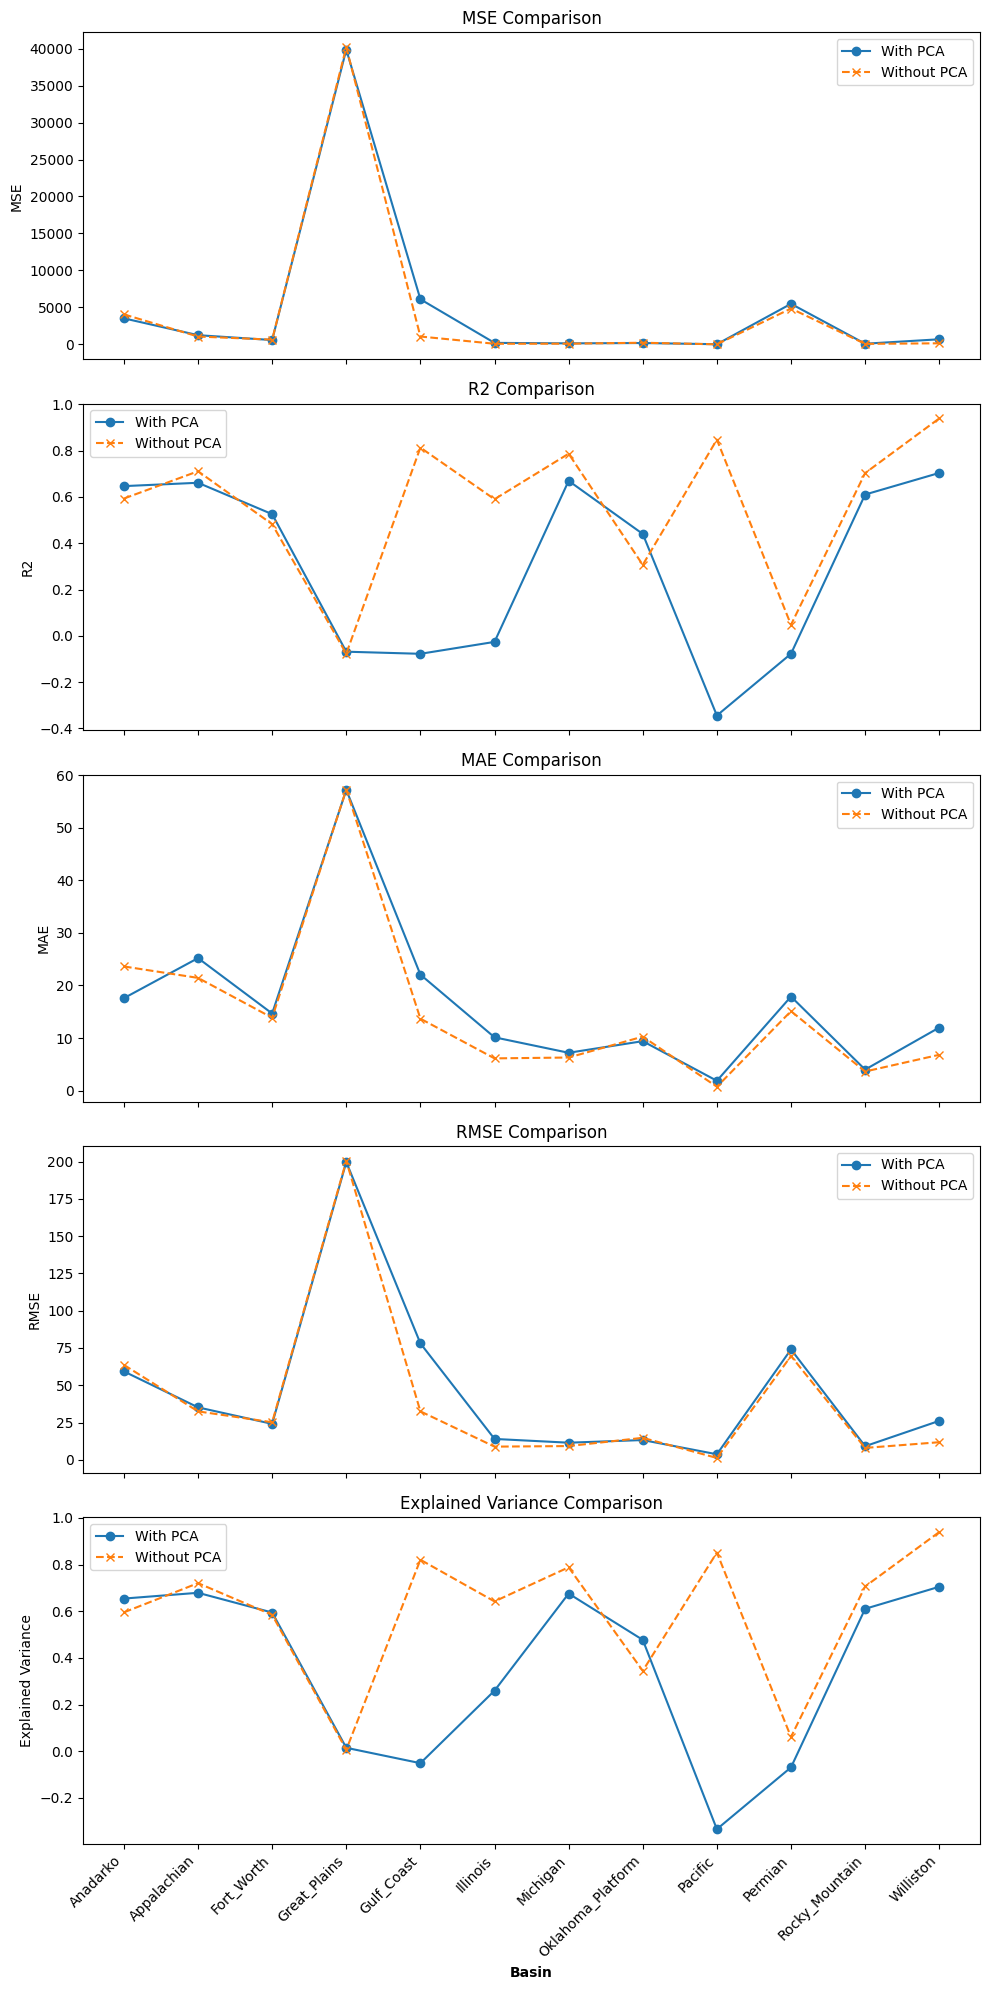

In [15]:
# Load results DataFrames
results_df_with_pca = pd.read_csv("../../data/performance_comparison/gradient_boosting_performance_pca.csv")
results_df_without_pca = pd.read_csv("../../data/performance_comparison/gradient_boosting_performance_no_PCA.csv")

# Replace spaces with underscores in the basin names
results_df_with_pca['Basin'] = results_df_with_pca['Basin'].str.replace(' ', '_')
results_df_without_pca['Basin'] = results_df_without_pca['Basin'].str.replace(' ', '_')

# Set 'Basin' as index now that the names are sanitized
results_df_with_pca.set_index('Basin', inplace=True)
results_df_without_pca.set_index('Basin', inplace=True)

# Merge the two results DataFrames
combined_results = results_df_with_pca.join(results_df_without_pca, lsuffix='_with_pca', rsuffix='_without_pca')

# Define the metrics to compare
metrics = ['MSE', 'R2', 'MAE', 'RMSE', 'Explained Variance']

# Create a figure and axes for the subplots
fig, axs = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 20), sharex=True)

# Plot comparisons for each metric
for idx, metric in enumerate(metrics):
    axs[idx].plot(combined_results.index, combined_results[metric + '_with_pca'], marker='o', label='With PCA', linestyle='-')
    axs[idx].plot(combined_results.index, combined_results[metric + '_without_pca'], marker='x', label='Without PCA', linestyle='--')
    
    axs[idx].set_ylabel(metric)
    axs[idx].set_title(metric + " Comparison")
    axs[idx].legend()

# Set common labels and adjust x-axis labels for better readability
plt.xlabel('Basin', fontweight='bold')
fig.autofmt_xdate(rotation=45)  

# Save the comparison plot
plt.tight_layout()  
plt.savefig("../../images/performance_comparison_plots/gradient_boosting_performance_comparison.png")
plt.show()  